### I221994 | Muhammad Qasim
### I222066 | Ayaan Khan
### I222003 | Muhammad Abubakar Nadeem

## Import Required Libraries

In [1]:
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cu129
CUDA available: True


## Model Definitions

In [2]:
class SimpleCNN(nn.Module):
    """Simple CNN for MNIST and Fashion-MNIST"""
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7 if input_channels==1 else 64*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        return self.fc(self.conv(x))

def get_resnet18(num_classes=10):
    """ResNet18 adapted for CIFAR-10"""
    model = torchvision.models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

print("Model architectures defined!")

Model architectures defined!


## Utility Functions

In [3]:
def model_to_vector(model):
    """Convert model parameters to a flat numpy vector"""
    return torch.cat([p.detach().flatten() for p in model.parameters()]).cpu().numpy()

def vector_to_model(model, vec):
    """Load vector into model parameters"""
    ptr = 0
    for p in model.parameters():
        num = p.numel()
        p.data.copy_(torch.tensor(vec[ptr:ptr+num]).view_as(p.data))
        ptr += num

def subtract_model_params(m_new, m_old):
    """Compute parameter update: new - old"""
    v_new = model_to_vector(m_new)
    v_old = model_to_vector(m_old)
    return v_new - v_old

def set_seed(seed):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print("Utility functions defined!")

Utility functions defined!


## Attack Implementations

In [4]:
def sign_flip_update(grad_vec):
    """Sign flipping attack: negate the gradient update"""
    return -grad_vec

def lie_attack_simulation(global_mean, global_std, beta=1.5):
    """LIE attack: craft malicious update near mean but in negative direction"""
    sign = -1.0
    return global_mean + sign * beta * global_std

print("Attack functions defined!")

Attack functions defined!


## Federated Learning Utilities

In [5]:
def local_train(model, train_loader, device, epochs=1, lr=0.01):
    """Train model locally for specified epochs"""
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    for e in range(epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

def fedavg(models):
    """Federated Averaging: average model parameters"""
    avg = {}
    for k in models[0].keys():
        avg[k] = sum([m[k].float() for m in models]) / len(models)
    return avg

def evaluate(model, dataloader, device):
    """Evaluate model accuracy on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    
    return correct / total

print("Federated learning functions defined!")

Federated learning functions defined!


## NC-FLD Defense: Weight Pruning, PCA, and Classification

In [6]:
def select_top_by_magnitude(grad_vec, keep_ratio):
    """Select top parameters by magnitude (weight pruning step)"""
    magnitudes = np.abs(grad_vec)
    threshold = np.quantile(magnitudes, 1 - keep_ratio)
    mask = magnitudes > threshold
    return grad_vec[mask], mask

def build_feature_matrix(selected_vectors):
    """Build feature matrix from selected parameters (pad to max length)"""
    max_len = max([v.shape[0] for v in selected_vectors])
    X = np.zeros((len(selected_vectors), max_len), dtype=np.float32)
    for i, v in enumerate(selected_vectors):
        X[i, :v.shape[0]] = v
    return X

def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction"""
    pca = PCA(n_components=n_components)
    Z = pca.fit_transform(X)
    return Z, pca

def classify_embeddings(Z, method='ocsvm'):
    """Classify clients as benign (True) or malicious (False)"""
    if method == 'ocsvm':
        clf = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')
        clf.fit(Z)
        preds = clf.predict(Z)  # +1 inlier, -1 outlier
        return (preds == 1).astype(bool)
    
    elif method == 'agg':
        cl = AgglomerativeClustering(n_clusters=2, linkage='average')
        labels = cl.fit_predict(Z)
        counts = np.bincount(labels)
        benign_label = np.argmax(counts)
        return (labels == benign_label).astype(bool)
    
    elif method == 'knn':
        k = 4
        kn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
        agg = AgglomerativeClustering(n_clusters=2)
        pseudo = agg.fit_predict(Z)
        counts = np.bincount(pseudo)
        benign_label = np.argmax(counts)
        y = (pseudo == benign_label).astype(int)
        kn.fit(Z, y)
        preds = kn.predict(Z)
        return (preds == 1).astype(bool)
    
    else:
        raise ValueError(f'Unknown defense method: {method}')

print("NC-FLD defense functions defined!")

NC-FLD defense functions defined!


## Main Simulation Function

In [7]:
# Create named tuple for experiment configuration
ExpConfig = namedtuple('ExpConfig', ['dataset', 'clients', 'rounds', 'local_epochs', 
                                     'lr', 'attack', 'malicious_ratio', 'defense', 
                                     'keep_ratio', 'seed', 'log_interval'])

def simulate(config):
    """
    Run federated learning simulation with NC-FLD defense
    
    Args:
        config: ExpConfig object with experiment parameters
    
    Returns:
        results: List of test accuracies per round
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(config.seed)
    
    # Dataset setup
    if config.dataset == 'mnist':
        transform = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize((0.5,), (0.5,))])
        trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                             download=True, transform=transform)
        testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                            download=True, transform=transform)
        model_fn = lambda: SimpleCNN(input_channels=1, num_classes=10)
        batch_size = 32
        flip_map = {7: 1}
    
    elif config.dataset == 'fmnist':
        transform = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize((0.5,), (0.5,))])
        trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                                     download=True, transform=transform)
        testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                    download=True, transform=transform)
        model_fn = lambda: SimpleCNN(input_channels=1, num_classes=10)
        batch_size = 25
        flip_map = {0: 6, 6: 0}
    
    elif config.dataset == 'cifar10':
        transform = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                               download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                              download=True, transform=transform)
        model_fn = lambda: get_resnet18(num_classes=10)
        batch_size = 100
        flip_map = {5: 3}  # dog -> cat
    
    else:
        raise NotImplementedError(f'Dataset {config.dataset} not implemented')
    
    # Create client data shards
    total_train = len(trainset)
    indices = list(range(total_train))
    random.shuffle(indices)
    shards = np.array_split(indices, config.clients)
    
    client_loaders = []
    for s in shards:
        sub = Subset(trainset, s)
        loader = DataLoader(sub, batch_size=batch_size, shuffle=True)
        client_loaders.append(loader)
    
    testloader = DataLoader(testset, batch_size=256, shuffle=False)
    
    # Select malicious clients
    num_mal = int(config.malicious_ratio * config.clients)
    mal_indices = set(random.sample(range(config.clients), num_mal))
    print(f"Malicious clients: {sorted(list(mal_indices))} (count={num_mal})")
    
    # Initialize global model
    global_model = model_fn().to(device)
    global_state = copy.deepcopy(global_model.state_dict())
    
    # Main federated learning rounds
    results = []
    for r in trange(config.rounds, desc='Training Rounds'):
        local_states = []
        grad_vectors = []
        raw_masks = []
        
        # Local training for each client
        for c in range(config.clients):
            model_c = model_fn().to(device)
            model_c.load_state_dict(global_state)
            old_model = copy.deepcopy(model_c)
            
            # Label flip attack: poison training data
            if config.attack == 'label_flip' and c in mal_indices:
                ds_indices = shards[c]
                poison_list = []
                for idx in ds_indices:
                    x, y = trainset[idx]
                    y_ = flip_map.get(int(y), int(y))
                    poison_list.append((x, y_))
                poisoned_loader = DataLoader(poison_list, batch_size=batch_size, shuffle=True)
                local_train(model_c, poisoned_loader, device, 
                          epochs=config.local_epochs, lr=config.lr)
            else:
                local_train(model_c, client_loaders[c], device, 
                          epochs=config.local_epochs, lr=config.lr)
            
            # Compute update vector
            diff_vec = subtract_model_params(model_c, old_model)
            
            # Model poisoning attacks
            if c in mal_indices and config.attack == 'sign_flip':
                diff_vec = sign_flip_update(diff_vec)
            
            if c in mal_indices and config.attack == 'lie':
                if len(grad_vectors) > 0:
                    global_mean = np.mean(np.stack(grad_vectors), axis=0)
                    global_std = np.std(np.stack(grad_vectors), axis=0) + 1e-6
                    diff_vec = lie_attack_simulation(global_mean, global_std, beta=1.0)
                else:
                    diff_vec = sign_flip_update(diff_vec)
            
            grad_vectors.append(diff_vec)
            local_states.append(model_c.state_dict())
        
        # NC-FLD Defense: Weight Pruning
        selected_vecs = []
        for vec in grad_vectors:
            sel, mask = select_top_by_magnitude(vec, config.keep_ratio)
            selected_vecs.append(sel)
            raw_masks.append(mask)
        
        # Build feature matrix and apply PCA
        X = build_feature_matrix(selected_vecs)
        Z, pca = apply_pca(X, n_components=2)
        
        # Classify clients
        benign_mask = classify_embeddings(Z, method=config.defense)
        benign_indices = [i for i, b in enumerate(benign_mask) if b]
        
        if len(benign_indices) == 0:
            print("Warning: all clients classified malicious; skipping aggregation")
            continue
        
        # Aggregate benign clients (FedAvg)
        benign_states = [local_states[i] for i in benign_indices]
        new_global_state = fedavg(benign_states)
        global_state = new_global_state
        
        # Evaluate
        global_model.load_state_dict(global_state)
        acc = evaluate(global_model, testloader, device)
        results.append(acc)
        
        if (r + 1) % config.log_interval == 0:
            print(f"Round {r+1}/{config.rounds} - Test Acc: {acc:.4f} - "
                  f"Included: {len(benign_indices)}/{config.clients}")
    
    final_acc = results[-1] if len(results) > 0 else None
    print(f"Final test accuracy: {final_acc:.4f}")
    
    # Save the final model
    import os
    os.makedirs('models', exist_ok=True)
    model_filename = f"models/{config.dataset}_{config.attack}_mr{config.malicious_ratio}_{config.defense}_final.pth"
    torch.save(global_model.state_dict(), model_filename)
    print(f"Model saved to: {model_filename}")
    
    return results, final_acc

print("Simulation function defined!")

Simulation function defined!


## Initialize Results Storage

In [8]:
# Storage for all experiment results
all_results = []

print("Results storage initialized!")

Results storage initialized!


---
# MNIST Experiments (100 clients)
## Label Flip Attack

In [9]:
# MNIST - Label Flip - Malicious Ratio 0.1 - OCSVM
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='label_flip', malicious_ratio=0.1, defense='ocsvm',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'label_flip', 'malicious_ratio': 0.1,
                   'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:38<24:00, 16.01s/it]

Round 10/100 - Test Acc: 0.6717 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:16<20:52, 15.66s/it]

Round 20/100 - Test Acc: 0.8691 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:52<18:04, 15.49s/it]

Round 30/100 - Test Acc: 0.9052 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [10:29<15:45, 15.75s/it]

Round 40/100 - Test Acc: 0.9196 - Included: 91/100


Training Rounds:  50%|█████     | 50/100 [13:03<12:49, 15.38s/it]

Round 50/100 - Test Acc: 0.9301 - Included: 91/100


Training Rounds:  60%|██████    | 60/100 [15:41<10:31, 15.78s/it]

Round 60/100 - Test Acc: 0.9385 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [18:21<07:59, 15.98s/it]

Round 70/100 - Test Acc: 0.9455 - Included: 91/100


Training Rounds:  80%|████████  | 80/100 [21:00<05:18, 15.92s/it]

Round 80/100 - Test Acc: 0.9507 - Included: 89/100


Training Rounds:  90%|█████████ | 90/100 [23:38<02:38, 15.82s/it]

Round 90/100 - Test Acc: 0.9552 - Included: 89/100


Training Rounds: 100%|██████████| 100/100 [26:16<00:00, 15.76s/it]

Round 100/100 - Test Acc: 0.9592 - Included: 92/100
Final test accuracy: 0.9592
Model saved to: models/mnist_label_flip_mr0.1_ocsvm_final.pth


In [10]:
# MNIST - Label Flip - Malicious Ratio 0.1 - AGG
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='label_flip', malicious_ratio=0.1, defense='agg',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'label_flip', 'malicious_ratio': 0.1,
                   'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:38<23:30, 15.68s/it]

Round 10/100 - Test Acc: 0.6825 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:17<21:08, 15.86s/it]

Round 20/100 - Test Acc: 0.8659 - Included: 99/100


Training Rounds:  30%|███       | 30/100 [07:56<18:35, 15.94s/it]

Round 30/100 - Test Acc: 0.9039 - Included: 98/100


Training Rounds:  40%|████      | 40/100 [10:35<15:52, 15.88s/it]

Round 40/100 - Test Acc: 0.9201 - Included: 95/100


Training Rounds:  50%|█████     | 50/100 [13:14<13:15, 15.91s/it]

Round 50/100 - Test Acc: 0.9307 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [15:53<10:32, 15.81s/it]

Round 60/100 - Test Acc: 0.9380 - Included: 97/100


Training Rounds:  70%|███████   | 70/100 [18:32<07:54, 15.83s/it]

Round 70/100 - Test Acc: 0.9460 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [21:11<05:16, 15.81s/it]

Round 80/100 - Test Acc: 0.9507 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [23:50<02:37, 15.77s/it]

Round 90/100 - Test Acc: 0.9555 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [26:29<00:00, 15.90s/it]

Round 100/100 - Test Acc: 0.9600 - Included: 90/100
Final test accuracy: 0.9600
Model saved to: models/mnist_label_flip_mr0.1_agg_final.pth


In [11]:
# MNIST - Label Flip - Malicious Ratio 0.1 - KNN
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='label_flip', malicious_ratio=0.1, defense='knn',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'label_flip', 'malicious_ratio': 0.1,
                   'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:33<23:00, 15.34s/it]

Round 10/100 - Test Acc: 0.6821 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:09<20:57, 15.72s/it]

Round 20/100 - Test Acc: 0.8708 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:51<19:29, 16.70s/it]

Round 30/100 - Test Acc: 0.9049 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [10:28<15:47, 15.78s/it]

Round 40/100 - Test Acc: 0.9214 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [13:05<12:59, 15.58s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [15:41<10:22, 15.55s/it]

Round 60/100 - Test Acc: 0.9390 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [18:17<07:48, 15.61s/it]

Round 70/100 - Test Acc: 0.9454 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [20:55<05:14, 15.73s/it]

Round 80/100 - Test Acc: 0.9500 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [23:30<02:35, 15.59s/it]

Round 90/100 - Test Acc: 0.9550 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [26:07<00:00, 15.68s/it]

Round 100/100 - Test Acc: 0.9595 - Included: 90/100
Final test accuracy: 0.9595


Model saved to: models/mnist_label_flip_mr0.1_knn_final.pth


In [12]:
# MNIST - Label Flip - Malicious Ratio 0.2 - All Defenses
for defense in ['ocsvm', 'agg', 'knn']:
    config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                       attack='label_flip', malicious_ratio=0.2, defense=defense,
                       keep_ratio=0.15, seed=42, log_interval=10)
    round_accs, final_acc = simulate(config)
    all_results.append({'dataset': 'mnist', 'attack': 'label_flip', 'malicious_ratio': 0.2,
                       'defense': defense, 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:37<23:35, 15.73s/it]

Round 10/100 - Test Acc: 0.6368 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:15<20:54, 15.68s/it]

Round 20/100 - Test Acc: 0.8613 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:51<18:11, 15.59s/it]

Round 30/100 - Test Acc: 0.9014 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [10:28<15:43, 15.73s/it]

Round 40/100 - Test Acc: 0.9152 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [13:06<13:09, 15.79s/it]

Round 50/100 - Test Acc: 0.9256 - Included: 92/100


Training Rounds:  60%|██████    | 60/100 [15:43<10:26, 15.66s/it]

Round 60/100 - Test Acc: 0.9352 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [18:20<07:49, 15.64s/it]

Round 70/100 - Test Acc: 0.9429 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [20:58<05:16, 15.83s/it]

Round 80/100 - Test Acc: 0.9484 - Included: 91/100


Training Rounds:  90%|█████████ | 90/100 [23:36<02:37, 15.71s/it]

Round 90/100 - Test Acc: 0.9539 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [26:12<00:00, 15.73s/it]


Round 100/100 - Test Acc: 0.9586 - Included: 89/100
Final test accuracy: 0.9586
Model saved to: models/mnist_label_flip_mr0.2_ocsvm_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:36<23:36, 15.74s/it]

Round 10/100 - Test Acc: 0.6841 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [05:14<20:55, 15.70s/it]

Round 20/100 - Test Acc: 0.8708 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [07:50<18:10, 15.58s/it]

Round 30/100 - Test Acc: 0.8986 - Included: 99/100


Training Rounds:  40%|████      | 40/100 [10:28<15:46, 15.77s/it]

Round 40/100 - Test Acc: 0.9200 - Included: 80/100


Training Rounds:  50%|█████     | 50/100 [13:04<12:58, 15.56s/it]

Round 50/100 - Test Acc: 0.9307 - Included: 80/100


Training Rounds:  60%|██████    | 60/100 [15:40<10:20, 15.52s/it]

Round 60/100 - Test Acc: 0.9392 - Included: 80/100


Training Rounds:  70%|███████   | 70/100 [18:17<07:51, 15.70s/it]

Round 70/100 - Test Acc: 0.9461 - Included: 80/100


Training Rounds:  80%|████████  | 80/100 [20:53<05:13, 15.66s/it]

Round 80/100 - Test Acc: 0.9504 - Included: 80/100


Training Rounds:  90%|█████████ | 90/100 [23:30<02:36, 15.68s/it]

Round 90/100 - Test Acc: 0.9554 - Included: 80/100


Training Rounds: 100%|██████████| 100/100 [26:06<00:00, 15.66s/it]


Round 100/100 - Test Acc: 0.9595 - Included: 80/100
Final test accuracy: 0.9595
Model saved to: models/mnist_label_flip_mr0.2_agg_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:36<23:31, 15.69s/it]

Round 10/100 - Test Acc: 0.6841 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [05:13<20:55, 15.69s/it]

Round 20/100 - Test Acc: 0.8703 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [07:50<18:16, 15.66s/it]

Round 30/100 - Test Acc: 0.9060 - Included: 80/100


Training Rounds:  40%|████      | 40/100 [10:27<15:43, 15.73s/it]

Round 40/100 - Test Acc: 0.9208 - Included: 80/100


Training Rounds:  50%|█████     | 50/100 [13:04<13:03, 15.66s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 80/100


Training Rounds:  60%|██████    | 60/100 [15:41<10:28, 15.71s/it]

Round 60/100 - Test Acc: 0.9391 - Included: 80/100


Training Rounds:  70%|███████   | 70/100 [18:18<07:50, 15.68s/it]

Round 70/100 - Test Acc: 0.9460 - Included: 80/100


Training Rounds:  80%|████████  | 80/100 [20:55<05:14, 15.71s/it]

Round 80/100 - Test Acc: 0.9501 - Included: 80/100


Training Rounds:  90%|█████████ | 90/100 [23:31<02:35, 15.55s/it]

Round 90/100 - Test Acc: 0.9556 - Included: 80/100


Training Rounds: 100%|██████████| 100/100 [26:09<00:00, 15.69s/it]

Round 100/100 - Test Acc: 0.9597 - Included: 80/100
Final test accuracy: 0.9597
Model saved to: models/mnist_label_flip_mr0.2_knn_final.pth


In [13]:
# MNIST - Label Flip - Malicious Ratio 0.3 - All Defenses
for defense in ['ocsvm', 'agg', 'knn']:
    config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                       attack='label_flip', malicious_ratio=0.3, defense=defense,
                       keep_ratio=0.15, seed=42, log_interval=10)
    round_accs, final_acc = simulate(config)
    all_results.append({'dataset': 'mnist', 'attack': 'label_flip', 'malicious_ratio': 0.3,
                       'defense': defense, 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:36<23:26, 15.62s/it]

Round 10/100 - Test Acc: 0.5755 - Included: 91/100


Training Rounds:  20%|██        | 20/100 [05:12<20:49, 15.62s/it]

Round 20/100 - Test Acc: 0.8487 - Included: 91/100


Training Rounds:  30%|███       | 30/100 [07:49<18:19, 15.70s/it]

Round 30/100 - Test Acc: 0.8928 - Included: 88/100


Training Rounds:  40%|████      | 40/100 [10:25<15:41, 15.69s/it]

Round 40/100 - Test Acc: 0.9079 - Included: 91/100


Training Rounds:  50%|█████     | 50/100 [13:01<12:54, 15.50s/it]

Round 50/100 - Test Acc: 0.9209 - Included: 93/100


Training Rounds:  60%|██████    | 60/100 [15:38<10:25, 15.63s/it]

Round 60/100 - Test Acc: 0.9305 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [18:14<07:48, 15.60s/it]

Round 70/100 - Test Acc: 0.9388 - Included: 89/100


Training Rounds:  80%|████████  | 80/100 [20:50<05:10, 15.51s/it]

Round 80/100 - Test Acc: 0.9439 - Included: 92/100


Training Rounds:  90%|█████████ | 90/100 [23:27<02:36, 15.70s/it]

Round 90/100 - Test Acc: 0.9496 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [26:02<00:00, 15.63s/it]


Round 100/100 - Test Acc: 0.9544 - Included: 91/100
Final test accuracy: 0.9544
Model saved to: models/mnist_label_flip_mr0.3_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:37<23:44, 15.83s/it]

Round 10/100 - Test Acc: 0.6838 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [05:14<21:01, 15.77s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [07:51<18:18, 15.70s/it]

Round 30/100 - Test Acc: 0.9063 - Included: 70/100


Training Rounds:  40%|████      | 40/100 [10:28<15:40, 15.68s/it]

Round 40/100 - Test Acc: 0.9205 - Included: 70/100


Training Rounds:  50%|█████     | 50/100 [13:05<13:00, 15.62s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 70/100


Training Rounds:  60%|██████    | 60/100 [15:42<10:29, 15.74s/it]

Round 60/100 - Test Acc: 0.9395 - Included: 70/100


Training Rounds:  70%|███████   | 70/100 [18:18<07:49, 15.65s/it]

Round 70/100 - Test Acc: 0.9462 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [20:55<05:14, 15.73s/it]

Round 80/100 - Test Acc: 0.9501 - Included: 70/100


Training Rounds:  90%|█████████ | 90/100 [23:33<02:38, 15.85s/it]

Round 90/100 - Test Acc: 0.9555 - Included: 70/100


Training Rounds: 100%|██████████| 100/100 [26:10<00:00, 15.71s/it]

Round 100/100 - Test Acc: 0.9589 - Included: 70/100
Final test accuracy: 0.9589


Model saved to: models/mnist_label_flip_mr0.3_agg_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:34<23:12, 15.47s/it]

Round 10/100 - Test Acc: 0.6838 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [05:09<20:43, 15.54s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [07:46<18:15, 15.65s/it]

Round 30/100 - Test Acc: 0.9062 - Included: 70/100


Training Rounds:  40%|████      | 40/100 [10:22<15:41, 15.69s/it]

Round 40/100 - Test Acc: 0.9210 - Included: 70/100


Training Rounds:  50%|█████     | 50/100 [13:02<13:18, 15.96s/it]

Round 50/100 - Test Acc: 0.9311 - Included: 70/100


Training Rounds:  60%|██████    | 60/100 [15:41<10:36, 15.92s/it]

Round 60/100 - Test Acc: 0.9400 - Included: 70/100


Training Rounds:  70%|███████   | 70/100 [18:20<07:57, 15.92s/it]

Round 70/100 - Test Acc: 0.9462 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [20:58<05:15, 15.77s/it]

Round 80/100 - Test Acc: 0.9500 - Included: 70/100


Training Rounds:  90%|█████████ | 90/100 [23:37<02:38, 15.88s/it]

Round 90/100 - Test Acc: 0.9552 - Included: 70/100


Training Rounds: 100%|██████████| 100/100 [26:15<00:00, 15.76s/it]

Round 100/100 - Test Acc: 0.9592 - Included: 70/100
Final test accuracy: 0.9592
Model saved to: models/mnist_label_flip_mr0.3_knn_final.pth


In [14]:
# MNIST - Label Flip - Malicious Ratio 0.4 - All Defenses
for defense in ['ocsvm', 'agg', 'knn']:
    config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                       attack='label_flip', malicious_ratio=0.4, defense=defense,
                       keep_ratio=0.15, seed=42, log_interval=10)
    round_accs, final_acc = simulate(config)
    all_results.append({'dataset': 'mnist', 'attack': 'label_flip', 'malicious_ratio': 0.4,
                       'defense': defense, 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:38<23:42, 15.81s/it]

Round 10/100 - Test Acc: 0.5621 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:16<20:53, 15.67s/it]

Round 20/100 - Test Acc: 0.8249 - Included: 91/100


Training Rounds:  30%|███       | 30/100 [07:54<18:16, 15.66s/it]

Round 30/100 - Test Acc: 0.8770 - Included: 91/100


Training Rounds:  40%|████      | 40/100 [10:33<15:49, 15.83s/it]

Round 40/100 - Test Acc: 0.8943 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [13:11<13:07, 15.75s/it]

Round 50/100 - Test Acc: 0.9089 - Included: 91/100


Training Rounds:  60%|██████    | 60/100 [15:49<10:30, 15.76s/it]

Round 60/100 - Test Acc: 0.9217 - Included: 87/100


Training Rounds:  70%|███████   | 70/100 [18:28<07:58, 15.94s/it]

Round 70/100 - Test Acc: 0.9281 - Included: 91/100


Training Rounds:  80%|████████  | 80/100 [21:07<05:17, 15.87s/it]

Round 80/100 - Test Acc: 0.9368 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [23:45<02:39, 15.92s/it]

Round 90/100 - Test Acc: 0.9407 - Included: 89/100


Training Rounds: 100%|██████████| 100/100 [26:23<00:00, 15.84s/it]


Round 100/100 - Test Acc: 0.9472 - Included: 92/100
Final test accuracy: 0.9472
Model saved to: models/mnist_label_flip_mr0.4_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:37<23:45, 15.83s/it]

Round 10/100 - Test Acc: 0.6748 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [05:16<21:12, 15.91s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [07:53<18:15, 15.66s/it]

Round 30/100 - Test Acc: 0.9058 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [10:32<15:49, 15.83s/it]

Round 40/100 - Test Acc: 0.9212 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [13:11<13:14, 15.89s/it]

Round 50/100 - Test Acc: 0.9311 - Included: 60/100


Training Rounds:  60%|██████    | 60/100 [15:48<10:31, 15.79s/it]

Round 60/100 - Test Acc: 0.9389 - Included: 60/100


Training Rounds:  70%|███████   | 70/100 [18:26<07:54, 15.80s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 60/100


Training Rounds:  80%|████████  | 80/100 [21:05<05:15, 15.79s/it]

Round 80/100 - Test Acc: 0.9499 - Included: 60/100


Training Rounds:  90%|█████████ | 90/100 [23:42<02:37, 15.76s/it]

Round 90/100 - Test Acc: 0.9550 - Included: 60/100


Training Rounds: 100%|██████████| 100/100 [26:21<00:00, 15.82s/it]


Round 100/100 - Test Acc: 0.9589 - Included: 60/100
Final test accuracy: 0.9589
Model saved to: models/mnist_label_flip_mr0.4_agg_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:37<23:30, 15.67s/it]

Round 10/100 - Test Acc: 0.6748 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [05:16<21:03, 15.79s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [07:54<18:15, 15.66s/it]

Round 30/100 - Test Acc: 0.9058 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [10:32<15:42, 15.71s/it]

Round 40/100 - Test Acc: 0.9212 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [13:11<13:08, 15.77s/it]

Round 50/100 - Test Acc: 0.9311 - Included: 60/100


Training Rounds:  60%|██████    | 60/100 [15:49<10:26, 15.67s/it]

Round 60/100 - Test Acc: 0.9389 - Included: 60/100


Training Rounds:  70%|███████   | 70/100 [18:28<07:57, 15.90s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 60/100


Training Rounds:  80%|████████  | 80/100 [21:06<05:16, 15.81s/it]

Round 80/100 - Test Acc: 0.9499 - Included: 60/100


Training Rounds:  90%|█████████ | 90/100 [23:45<02:38, 15.81s/it]

Round 90/100 - Test Acc: 0.9550 - Included: 60/100


Training Rounds: 100%|██████████| 100/100 [26:23<00:00, 15.83s/it]

Round 100/100 - Test Acc: 0.9589 - Included: 60/100
Final test accuracy: 0.9589
Model saved to: models/mnist_label_flip_mr0.4_knn_final.pth


## Sign Flip Attack

In [15]:
# MNIST - Sign Flip - All Malicious Ratios and Defenses
for ratio in [0.1, 0.2, 0.3, 0.4]:
    for defense in ['ocsvm', 'agg', 'knn']:
        config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                           attack='sign_flip', malicious_ratio=ratio, defense=defense,
                           keep_ratio=0.15, seed=42, log_interval=10)
        round_accs, final_acc = simulate(config)
        all_results.append({'dataset': 'mnist', 'attack': 'sign_flip', 'malicious_ratio': ratio,
                           'defense': defense, 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:35<23:27, 15.64s/it]

Round 10/100 - Test Acc: 0.6867 - Included: 91/100


Training Rounds:  20%|██        | 20/100 [05:13<21:00, 15.76s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:49<18:20, 15.72s/it]

Round 30/100 - Test Acc: 0.9056 - Included: 88/100


Training Rounds:  40%|████      | 40/100 [10:26<15:39, 15.66s/it]

Round 40/100 - Test Acc: 0.9218 - Included: 89/100


Training Rounds:  50%|█████     | 50/100 [13:02<12:59, 15.60s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 89/100


Training Rounds:  60%|██████    | 60/100 [15:39<10:23, 15.58s/it]

Round 60/100 - Test Acc: 0.9392 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [18:16<07:51, 15.72s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 87/100


Training Rounds:  80%|████████  | 80/100 [20:52<05:13, 15.65s/it]

Round 80/100 - Test Acc: 0.9504 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [23:28<02:36, 15.70s/it]

Round 90/100 - Test Acc: 0.9558 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [26:03<00:00, 15.64s/it]


Round 100/100 - Test Acc: 0.9597 - Included: 88/100
Final test accuracy: 0.9597
Model saved to: models/mnist_sign_flip_mr0.1_ocsvm_final.pth
Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:35<23:15, 15.51s/it]

Round 10/100 - Test Acc: 0.6826 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:11<20:51, 15.64s/it]

Round 20/100 - Test Acc: 0.8706 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:47<18:10, 15.58s/it]

Round 30/100 - Test Acc: 0.9054 - Included: 96/100


Training Rounds:  40%|████      | 40/100 [10:24<15:43, 15.72s/it]

Round 40/100 - Test Acc: 0.9213 - Included: 96/100


Training Rounds:  50%|█████     | 50/100 [13:00<12:59, 15.59s/it]

Round 50/100 - Test Acc: 0.9308 - Included: 99/100


Training Rounds:  60%|██████    | 60/100 [15:36<10:22, 15.57s/it]

Round 60/100 - Test Acc: 0.9391 - Included: 96/100


Training Rounds:  70%|███████   | 70/100 [18:12<07:47, 15.59s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 99/100


Training Rounds:  80%|████████  | 80/100 [20:47<05:11, 15.56s/it]

Round 80/100 - Test Acc: 0.9504 - Included: 99/100


Training Rounds:  90%|█████████ | 90/100 [23:24<02:36, 15.68s/it]

Round 90/100 - Test Acc: 0.9561 - Included: 99/100


Training Rounds: 100%|██████████| 100/100 [26:01<00:00, 15.61s/it]


Round 100/100 - Test Acc: 0.9597 - Included: 99/100
Final test accuracy: 0.9597
Model saved to: models/mnist_sign_flip_mr0.1_agg_final.pth
Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:35<23:19, 15.55s/it]

Round 10/100 - Test Acc: 0.6820 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:11<20:49, 15.62s/it]

Round 20/100 - Test Acc: 0.8706 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [07:47<18:08, 15.56s/it]

Round 30/100 - Test Acc: 0.9067 - Included: 75/100


Training Rounds:  40%|████      | 40/100 [10:23<15:36, 15.61s/it]

Round 40/100 - Test Acc: 0.9200 - Included: 65/100


Training Rounds:  50%|█████     | 50/100 [12:59<13:03, 15.68s/it]

Round 50/100 - Test Acc: 0.9321 - Included: 55/100


Training Rounds:  60%|██████    | 60/100 [15:35<10:25, 15.64s/it]

Round 60/100 - Test Acc: 0.9390 - Included: 78/100


Training Rounds:  70%|███████   | 70/100 [18:11<07:50, 15.69s/it]

Round 70/100 - Test Acc: 0.9453 - Included: 64/100


Training Rounds:  80%|████████  | 80/100 [20:48<05:12, 15.64s/it]

Round 80/100 - Test Acc: 0.9504 - Included: 53/100


Training Rounds:  90%|█████████ | 90/100 [23:24<02:36, 15.70s/it]

Round 90/100 - Test Acc: 0.9556 - Included: 59/100


Training Rounds: 100%|██████████| 100/100 [25:59<00:00, 15.60s/it]

Round 100/100 - Test Acc: 0.9592 - Included: 77/100
Final test accuracy: 0.9592


Model saved to: models/mnist_sign_flip_mr0.1_knn_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:33<22:59, 15.33s/it]

Round 10/100 - Test Acc: 0.6865 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:06<20:20, 15.26s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 91/100


Training Rounds:  30%|███       | 30/100 [07:39<17:44, 15.21s/it]

Round 30/100 - Test Acc: 0.9055 - Included: 86/100


Training Rounds:  40%|████      | 40/100 [10:13<15:26, 15.44s/it]

Round 40/100 - Test Acc: 0.9211 - Included: 85/100


Training Rounds:  50%|█████     | 50/100 [12:49<13:06, 15.73s/it]

Round 50/100 - Test Acc: 0.9313 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [15:27<10:32, 15.81s/it]

Round 60/100 - Test Acc: 0.9390 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [18:03<07:46, 15.55s/it]

Round 70/100 - Test Acc: 0.9460 - Included: 91/100


Training Rounds:  80%|████████  | 80/100 [20:39<05:09, 15.48s/it]

Round 80/100 - Test Acc: 0.9505 - Included: 88/100


Training Rounds:  90%|█████████ | 90/100 [23:15<02:36, 15.68s/it]

Round 90/100 - Test Acc: 0.9561 - Included: 88/100


Training Rounds: 100%|██████████| 100/100 [25:52<00:00, 15.52s/it]


Round 100/100 - Test Acc: 0.9596 - Included: 89/100
Final test accuracy: 0.9596
Model saved to: models/mnist_sign_flip_mr0.2_ocsvm_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:36<23:35, 15.73s/it]

Round 10/100 - Test Acc: 0.6845 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [05:13<20:57, 15.72s/it]

Round 20/100 - Test Acc: 0.8703 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [07:49<18:21, 15.73s/it]

Round 30/100 - Test Acc: 0.9056 - Included: 99/100


Training Rounds:  40%|████      | 40/100 [10:27<15:43, 15.73s/it]

Round 40/100 - Test Acc: 0.9218 - Included: 98/100


Training Rounds:  50%|█████     | 50/100 [13:03<13:00, 15.60s/it]

Round 50/100 - Test Acc: 0.9308 - Included: 99/100


Training Rounds:  60%|██████    | 60/100 [15:39<10:25, 15.63s/it]

Round 60/100 - Test Acc: 0.9396 - Included: 99/100


Training Rounds:  70%|███████   | 70/100 [18:16<07:47, 15.58s/it]

Round 70/100 - Test Acc: 0.9456 - Included: 99/100


Training Rounds:  80%|████████  | 80/100 [20:52<05:13, 15.67s/it]

Round 80/100 - Test Acc: 0.9505 - Included: 99/100


Training Rounds:  90%|█████████ | 90/100 [23:27<02:34, 15.45s/it]

Round 90/100 - Test Acc: 0.9561 - Included: 99/100


Training Rounds: 100%|██████████| 100/100 [26:03<00:00, 15.64s/it]


Round 100/100 - Test Acc: 0.9596 - Included: 99/100
Final test accuracy: 0.9596
Model saved to: models/mnist_sign_flip_mr0.2_agg_final.pth
Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:36<23:34, 15.72s/it]

Round 10/100 - Test Acc: 0.6841 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [05:12<20:47, 15.59s/it]

Round 20/100 - Test Acc: 0.8703 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [07:50<18:21, 15.74s/it]

Round 30/100 - Test Acc: 0.9057 - Included: 73/100


Training Rounds:  40%|████      | 40/100 [10:26<15:41, 15.69s/it]

Round 40/100 - Test Acc: 0.9209 - Included: 59/100


Training Rounds:  50%|█████     | 50/100 [13:04<13:03, 15.66s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 56/100


Training Rounds:  60%|██████    | 60/100 [15:41<10:28, 15.71s/it]

Round 60/100 - Test Acc: 0.9391 - Included: 65/100


Training Rounds:  70%|███████   | 70/100 [18:18<07:49, 15.66s/it]

Round 70/100 - Test Acc: 0.9459 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [20:54<05:13, 15.66s/it]

Round 80/100 - Test Acc: 0.9507 - Included: 74/100


Training Rounds:  90%|█████████ | 90/100 [23:31<02:37, 15.72s/it]

Round 90/100 - Test Acc: 0.9554 - Included: 50/100


Training Rounds: 100%|██████████| 100/100 [26:08<00:00, 15.69s/it]


Round 100/100 - Test Acc: 0.9597 - Included: 88/100
Final test accuracy: 0.9597
Model saved to: models/mnist_sign_flip_mr0.2_knn_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:36<23:29, 15.66s/it]

Round 10/100 - Test Acc: 0.6858 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:13<20:55, 15.69s/it]

Round 20/100 - Test Acc: 0.8715 - Included: 92/100


Training Rounds:  30%|███       | 30/100 [07:51<18:18, 15.69s/it]

Round 30/100 - Test Acc: 0.9052 - Included: 91/100


Training Rounds:  40%|████      | 40/100 [10:26<15:37, 15.62s/it]

Round 40/100 - Test Acc: 0.9217 - Included: 88/100


Training Rounds:  50%|█████     | 50/100 [13:03<12:59, 15.58s/it]

Round 50/100 - Test Acc: 0.9307 - Included: 87/100


Training Rounds:  60%|██████    | 60/100 [15:40<10:28, 15.71s/it]

Round 60/100 - Test Acc: 0.9390 - Included: 91/100


Training Rounds:  70%|███████   | 70/100 [18:16<07:49, 15.67s/it]

Round 70/100 - Test Acc: 0.9456 - Included: 91/100


Training Rounds:  80%|████████  | 80/100 [20:52<05:10, 15.51s/it]

Round 80/100 - Test Acc: 0.9506 - Included: 85/100


Training Rounds:  90%|█████████ | 90/100 [23:29<02:36, 15.65s/it]

Round 90/100 - Test Acc: 0.9559 - Included: 92/100


Training Rounds: 100%|██████████| 100/100 [26:06<00:00, 15.67s/it]


Round 100/100 - Test Acc: 0.9597 - Included: 88/100
Final test accuracy: 0.9597
Model saved to: models/mnist_sign_flip_mr0.3_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:36<23:28, 15.65s/it]

Round 10/100 - Test Acc: 0.6838 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [05:12<20:47, 15.59s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [07:49<18:27, 15.82s/it]

Round 30/100 - Test Acc: 0.9058 - Included: 96/100


Training Rounds:  40%|████      | 40/100 [10:39<16:25, 16.42s/it]

Round 40/100 - Test Acc: 0.9219 - Included: 98/100


Training Rounds:  48%|████▊     | 48/100 [12:53<13:57, 16.11s/it]


KeyboardInterrupt: 

In [17]:
# MNIST - Sign Flip - Malicious Ratio 0.3 - KNN
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='sign_flip', malicious_ratio=0.3, defense='knn',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'sign_flip', 'malicious_ratio': 0.3,
                   'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:47<24:43, 16.49s/it]

Round 10/100 - Test Acc: 0.6838 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [05:27<21:16, 15.96s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [08:06<18:28, 15.83s/it]

Round 30/100 - Test Acc: 0.9067 - Included: 73/100


Training Rounds:  40%|████      | 40/100 [10:48<16:08, 16.14s/it]

Round 40/100 - Test Acc: 0.9203 - Included: 59/100


Training Rounds:  50%|█████     | 50/100 [13:31<13:32, 16.24s/it]

Round 50/100 - Test Acc: 0.9323 - Included: 60/100


Training Rounds:  60%|██████    | 60/100 [16:13<10:51, 16.29s/it]

Round 60/100 - Test Acc: 0.9383 - Included: 53/100


Training Rounds:  70%|███████   | 70/100 [18:55<08:06, 16.21s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 52/100


Training Rounds:  80%|████████  | 80/100 [21:37<05:24, 16.24s/it]

Round 80/100 - Test Acc: 0.9501 - Included: 64/100


Training Rounds:  90%|█████████ | 90/100 [24:19<02:41, 16.20s/it]

Round 90/100 - Test Acc: 0.9555 - Included: 76/100


Training Rounds: 100%|██████████| 100/100 [27:01<00:00, 16.22s/it]

Round 100/100 - Test Acc: 0.9598 - Included: 63/100
Final test accuracy: 0.9598


Model saved to: models/mnist_sign_flip_mr0.3_knn_final.pth


In [18]:
# MNIST - Sabel Flip - Malicious Ratio 0.3 - AGG
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='sign_flip', malicious_ratio=0.3, defense='agg',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'sign_flip', 'malicious_ratio': 0.3,
                   'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:42<24:10, 16.11s/it]

Round 10/100 - Test Acc: 0.6838 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [05:23<21:28, 16.11s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [08:04<18:46, 16.09s/it]

Round 30/100 - Test Acc: 0.9058 - Included: 96/100


Training Rounds:  40%|████      | 40/100 [10:47<16:18, 16.31s/it]

Round 40/100 - Test Acc: 0.9219 - Included: 98/100


Training Rounds:  50%|█████     | 50/100 [13:33<13:43, 16.48s/it]

Round 50/100 - Test Acc: 0.9303 - Included: 99/100


Training Rounds:  60%|██████    | 60/100 [16:13<10:36, 15.92s/it]

Round 60/100 - Test Acc: 0.9395 - Included: 99/100


Training Rounds:  70%|███████   | 70/100 [18:55<08:13, 16.45s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 99/100


Training Rounds:  80%|████████  | 80/100 [21:39<05:27, 16.38s/it]

Round 80/100 - Test Acc: 0.9503 - Included: 99/100


Training Rounds:  90%|█████████ | 90/100 [24:21<02:39, 15.98s/it]

Round 90/100 - Test Acc: 0.9560 - Included: 99/100


Training Rounds: 100%|██████████| 100/100 [26:59<00:00, 16.19s/it]

Round 100/100 - Test Acc: 0.9596 - Included: 98/100
Final test accuracy: 0.9596
Model saved to: models/mnist_sign_flip_mr0.3_agg_final.pth


In [19]:
# MNIST - Sabel Flip - Malicious Ratio 0.4 - ocsvm
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='sign_flip', malicious_ratio=0.4, defense='ocsvm',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'sign_flip', 'malicious_ratio': 0.4,
                   'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:41<24:18, 16.20s/it]

Round 10/100 - Test Acc: 0.6864 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:19<21:02, 15.78s/it]

Round 20/100 - Test Acc: 0.8724 - Included: 88/100


Training Rounds:  30%|███       | 30/100 [08:00<18:50, 16.15s/it]

Round 30/100 - Test Acc: 0.9054 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [10:41<16:02, 16.04s/it]

Round 40/100 - Test Acc: 0.9222 - Included: 87/100


Training Rounds:  50%|█████     | 50/100 [13:22<13:24, 16.10s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 89/100


Training Rounds:  60%|██████    | 60/100 [16:03<10:41, 16.03s/it]

Round 60/100 - Test Acc: 0.9391 - Included: 87/100


Training Rounds:  70%|███████   | 70/100 [18:44<08:01, 16.04s/it]

Round 70/100 - Test Acc: 0.9458 - Included: 89/100


Training Rounds:  80%|████████  | 80/100 [21:25<05:19, 16.00s/it]

Round 80/100 - Test Acc: 0.9507 - Included: 87/100


Training Rounds:  90%|█████████ | 90/100 [24:07<02:41, 16.12s/it]

Round 90/100 - Test Acc: 0.9561 - Included: 89/100


Training Rounds: 100%|██████████| 100/100 [26:48<00:00, 16.08s/it]

Round 100/100 - Test Acc: 0.9595 - Included: 87/100
Final test accuracy: 0.9595
Model saved to: models/mnist_sign_flip_mr0.4_ocsvm_final.pth


In [20]:
# MNIST - Sabel Flip - Malicious Ratio 0.4 - agg
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='sign_flip', malicious_ratio=0.4, defense='agg',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'sign_flip', 'malicious_ratio': 0.4,
                   'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:42<24:18, 16.20s/it]

Round 10/100 - Test Acc: 0.6748 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [05:24<21:38, 16.23s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [08:04<18:43, 16.05s/it]

Round 30/100 - Test Acc: 0.9058 - Included: 95/100


Training Rounds:  40%|████      | 40/100 [10:46<16:19, 16.33s/it]

Round 40/100 - Test Acc: 0.9218 - Included: 98/100


Training Rounds:  50%|█████     | 50/100 [13:28<13:28, 16.18s/it]

Round 50/100 - Test Acc: 0.9305 - Included: 97/100


Training Rounds:  60%|██████    | 60/100 [16:10<10:46, 16.17s/it]

Round 60/100 - Test Acc: 0.9394 - Included: 99/100


Training Rounds:  70%|███████   | 70/100 [18:52<08:07, 16.23s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 97/100


Training Rounds:  80%|████████  | 80/100 [21:33<05:20, 16.00s/it]

Round 80/100 - Test Acc: 0.9504 - Included: 99/100


Training Rounds:  90%|█████████ | 90/100 [24:15<02:41, 16.14s/it]

Round 90/100 - Test Acc: 0.9559 - Included: 99/100


Training Rounds: 100%|██████████| 100/100 [26:57<00:00, 16.18s/it]

Round 100/100 - Test Acc: 0.9597 - Included: 98/100
Final test accuracy: 0.9597
Model saved to: models/mnist_sign_flip_mr0.4_agg_final.pth


In [21]:
# MNIST - Sabel Flip - Malicious Ratio 0.4 - knn
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='sign_flip', malicious_ratio=0.4, defense='knn',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'sign_flip', 'malicious_ratio': 0.4,
                   'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [02:39<23:54, 15.94s/it]

Round 10/100 - Test Acc: 0.6750 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [05:21<21:28, 16.10s/it]

Round 20/100 - Test Acc: 0.8708 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [08:01<18:42, 16.03s/it]

Round 30/100 - Test Acc: 0.9052 - Included: 58/100


Training Rounds:  40%|████      | 40/100 [10:42<16:04, 16.07s/it]

Round 40/100 - Test Acc: 0.9203 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [13:24<13:34, 16.30s/it]

Round 50/100 - Test Acc: 0.9295 - Included: 71/100


Training Rounds:  60%|██████    | 60/100 [16:04<10:37, 15.93s/it]

Round 60/100 - Test Acc: 0.9387 - Included: 55/100


Training Rounds:  70%|███████   | 70/100 [18:45<08:04, 16.16s/it]

Round 70/100 - Test Acc: 0.9454 - Included: 52/100


Training Rounds:  80%|████████  | 80/100 [21:25<05:21, 16.08s/it]

Round 80/100 - Test Acc: 0.9504 - Included: 63/100


Training Rounds:  90%|█████████ | 90/100 [24:07<02:41, 16.17s/it]

Round 90/100 - Test Acc: 0.9558 - Included: 51/100


Training Rounds: 100%|██████████| 100/100 [26:47<00:00, 16.08s/it]

Round 100/100 - Test Acc: 0.9591 - Included: 50/100
Final test accuracy: 0.9591
Model saved to: models/mnist_sign_flip_mr0.4_knn_final.pth


## LIE Attack

In [10]:
# MNIST - LIE - All Defenses
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='lie', malicious_ratio=0.1, defense='ocsvm',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.1,
                   'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:43<24:15, 16.17s/it]

Round 10/100 - Test Acc: 0.6852 - Included: 89/100


Training Rounds:  20%|██        | 20/100 [05:28<21:58, 16.48s/it]

Round 20/100 - Test Acc: 0.8704 - Included: 89/100


Training Rounds:  30%|███       | 30/100 [08:17<19:24, 16.63s/it]

Round 30/100 - Test Acc: 0.9053 - Included: 87/100


Training Rounds:  40%|████      | 40/100 [11:02<16:30, 16.50s/it]

Round 40/100 - Test Acc: 0.9205 - Included: 93/100


Training Rounds:  50%|█████     | 50/100 [13:48<13:43, 16.47s/it]

Round 50/100 - Test Acc: 0.9305 - Included: 89/100


Training Rounds:  60%|██████    | 60/100 [16:32<10:57, 16.43s/it]

Round 60/100 - Test Acc: 0.9393 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [19:15<08:11, 16.38s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 88/100


Training Rounds:  80%|████████  | 80/100 [22:01<05:29, 16.47s/it]

Round 80/100 - Test Acc: 0.9504 - Included: 89/100


Training Rounds:  90%|█████████ | 90/100 [24:47<02:44, 16.47s/it]

Round 90/100 - Test Acc: 0.9553 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [27:30<00:00, 16.50s/it]

Round 100/100 - Test Acc: 0.9596 - Included: 88/100
Final test accuracy: 0.9596
Model saved to: models/mnist_lie_mr0.1_ocsvm_final.pth


In [11]:
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                       attack='lie', malicious_ratio=0.1, defense='agg',
                       keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.1,
                       'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:44<24:39, 16.44s/it]

Round 10/100 - Test Acc: 0.6821 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:30<22:02, 16.54s/it]

Round 20/100 - Test Acc: 0.8708 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [08:15<19:09, 16.42s/it]

Round 30/100 - Test Acc: 0.9049 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [11:03<16:38, 16.64s/it]

Round 40/100 - Test Acc: 0.9214 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [13:49<13:46, 16.54s/it]

Round 50/100 - Test Acc: 0.9308 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [16:36<11:02, 16.57s/it]

Round 60/100 - Test Acc: 0.9389 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [19:22<08:19, 16.65s/it]

Round 70/100 - Test Acc: 0.9455 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [22:06<05:28, 16.41s/it]

Round 80/100 - Test Acc: 0.9500 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [24:48<02:41, 16.17s/it]

Round 90/100 - Test Acc: 0.9550 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [27:33<00:00, 16.54s/it]

Round 100/100 - Test Acc: 0.9595 - Included: 90/100
Final test accuracy: 0.9595
Model saved to: models/mnist_lie_mr0.1_agg_final.pth


In [9]:
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                       attack='lie', malicious_ratio=0.1, defense='knn',
                       keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.1,
                   'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 20, 41, 54, 59, 72, 80, 83, 84] (count=10)


Training Rounds:  10%|█         | 10/100 [02:45<24:42, 16.47s/it]

Round 10/100 - Test Acc: 0.6821 - Included: 90/100


Training Rounds:  20%|██        | 20/100 [05:33<22:34, 16.93s/it]

Round 20/100 - Test Acc: 0.8708 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [08:20<19:35, 16.80s/it]

Round 30/100 - Test Acc: 0.9049 - Included: 90/100


Training Rounds:  40%|████      | 40/100 [11:07<16:43, 16.72s/it]

Round 40/100 - Test Acc: 0.9214 - Included: 90/100


Training Rounds:  50%|█████     | 50/100 [13:54<13:55, 16.70s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 90/100


Training Rounds:  60%|██████    | 60/100 [16:40<11:04, 16.60s/it]

Round 60/100 - Test Acc: 0.9390 - Included: 90/100


Training Rounds:  70%|███████   | 70/100 [19:28<08:23, 16.80s/it]

Round 70/100 - Test Acc: 0.9454 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [22:15<05:34, 16.72s/it]

Round 80/100 - Test Acc: 0.9500 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [25:01<02:46, 16.69s/it]

Round 90/100 - Test Acc: 0.9550 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [27:47<00:00, 16.67s/it]

Round 100/100 - Test Acc: 0.9595 - Included: 90/100
Final test accuracy: 0.9595
Model saved to: models/mnist_lie_mr0.1_knn_final.pth


In [10]:
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                   attack='lie', malicious_ratio=0.2, defense='ocsvm',
                   keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.2,
                   'defense': 'ocsvm', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:54<26:07, 17.42s/it]

Round 10/100 - Test Acc: 0.6907 - Included: 88/100


Training Rounds:  20%|██        | 20/100 [05:48<23:00, 17.25s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 90/100


Training Rounds:  30%|███       | 30/100 [08:41<20:19, 17.43s/it]

Round 30/100 - Test Acc: 0.9059 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [11:36<17:24, 17.40s/it]

Round 40/100 - Test Acc: 0.9212 - Included: 89/100


Training Rounds:  50%|█████     | 50/100 [14:31<14:35, 17.51s/it]

Round 50/100 - Test Acc: 0.9312 - Included: 91/100


Training Rounds:  60%|██████    | 60/100 [17:26<11:35, 17.39s/it]

Round 60/100 - Test Acc: 0.9394 - Included: 89/100


Training Rounds:  70%|███████   | 70/100 [20:21<08:41, 17.39s/it]

Round 70/100 - Test Acc: 0.9453 - Included: 89/100


Training Rounds:  80%|████████  | 80/100 [23:16<05:50, 17.50s/it]

Round 80/100 - Test Acc: 0.9505 - Included: 91/100


Training Rounds:  90%|█████████ | 90/100 [26:11<02:54, 17.50s/it]

Round 90/100 - Test Acc: 0.9558 - Included: 89/100


Training Rounds: 100%|██████████| 100/100 [29:05<00:00, 17.46s/it]

Round 100/100 - Test Acc: 0.9599 - Included: 90/100
Final test accuracy: 0.9599
Model saved to: models/mnist_lie_mr0.2_ocsvm_final.pth


In [11]:
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                           attack='lie', malicious_ratio=0.2, defense='agg',
                           keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.2,
                           'defense': 'agg', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:55<26:08, 17.42s/it]

Round 10/100 - Test Acc: 0.6841 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [05:51<23:16, 17.46s/it]

Round 20/100 - Test Acc: 0.8703 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [08:46<20:17, 17.39s/it]

Round 30/100 - Test Acc: 0.9060 - Included: 80/100


Training Rounds:  40%|████      | 40/100 [11:43<17:28, 17.47s/it]

Round 40/100 - Test Acc: 0.9208 - Included: 80/100


Training Rounds:  50%|█████     | 50/100 [14:36<14:27, 17.35s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 80/100


Training Rounds:  60%|██████    | 60/100 [17:32<11:44, 17.61s/it]

Round 60/100 - Test Acc: 0.9391 - Included: 80/100


Training Rounds:  70%|███████   | 70/100 [20:26<08:38, 17.27s/it]

Round 70/100 - Test Acc: 0.9460 - Included: 80/100


Training Rounds:  80%|████████  | 80/100 [23:20<05:46, 17.33s/it]

Round 80/100 - Test Acc: 0.9501 - Included: 80/100


Training Rounds:  90%|█████████ | 90/100 [26:18<02:58, 17.85s/it]

Round 90/100 - Test Acc: 0.9556 - Included: 80/100


Training Rounds: 100%|██████████| 100/100 [29:14<00:00, 17.55s/it]

Round 100/100 - Test Acc: 0.9597 - Included: 80/100
Final test accuracy: 0.9597
Model saved to: models/mnist_lie_mr0.2_agg_final.pth


In [12]:
config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                           attack='lie', malicious_ratio=0.2, defense='knn',
                           keep_ratio=0.15, seed=42, log_interval=10)
round_accs, final_acc = simulate(config)
all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.2,
                           'defense': 'knn', 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 12, 20, 23, 35, 41, 54, 59, 65, 72, 76, 78, 80, 83, 84, 87, 88, 93, 99] (count=20)


Training Rounds:  10%|█         | 10/100 [02:53<26:09, 17.44s/it]

Round 10/100 - Test Acc: 0.6841 - Included: 80/100


Training Rounds:  20%|██        | 20/100 [05:47<23:02, 17.28s/it]

Round 20/100 - Test Acc: 0.8703 - Included: 80/100


Training Rounds:  30%|███       | 30/100 [08:44<20:37, 17.67s/it]

Round 30/100 - Test Acc: 0.9060 - Included: 80/100


Training Rounds:  40%|████      | 40/100 [11:39<17:24, 17.41s/it]

Round 40/100 - Test Acc: 0.9208 - Included: 80/100


Training Rounds:  50%|█████     | 50/100 [14:32<14:31, 17.43s/it]

Round 50/100 - Test Acc: 0.9309 - Included: 80/100


Training Rounds:  60%|██████    | 60/100 [17:29<11:45, 17.63s/it]

Round 60/100 - Test Acc: 0.9391 - Included: 80/100


Training Rounds:  70%|███████   | 70/100 [20:25<08:44, 17.49s/it]

Round 70/100 - Test Acc: 0.9460 - Included: 80/100


Training Rounds:  80%|████████  | 80/100 [23:19<05:48, 17.45s/it]

Round 80/100 - Test Acc: 0.9501 - Included: 80/100


Training Rounds:  90%|█████████ | 90/100 [26:11<02:51, 17.13s/it]

Round 90/100 - Test Acc: 0.9556 - Included: 80/100


Training Rounds: 100%|██████████| 100/100 [29:03<00:00, 17.44s/it]

Round 100/100 - Test Acc: 0.9597 - Included: 80/100
Final test accuracy: 0.9597
Model saved to: models/mnist_lie_mr0.2_knn_final.pth


In [14]:
for defense in ['ocsvm', 'agg', 'knn']:
        config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                           attack='lie', malicious_ratio=0.3, defense=defense,
                           keep_ratio=0.15, seed=42, log_interval=10)
        round_accs, final_acc = simulate(config)
        all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.3,
                           'defense': defense, 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [02:58<26:56, 17.96s/it]

Round 10/100 - Test Acc: 0.6871 - Included: 89/100


Training Rounds:  20%|██        | 20/100 [06:02<24:15, 18.20s/it]

Round 20/100 - Test Acc: 0.8708 - Included: 92/100


Training Rounds:  30%|███       | 30/100 [09:00<20:54, 17.93s/it]

Round 30/100 - Test Acc: 0.9049 - Included: 89/100


Training Rounds:  40%|████      | 40/100 [12:02<18:07, 18.13s/it]

Round 40/100 - Test Acc: 0.9206 - Included: 88/100


Training Rounds:  50%|█████     | 50/100 [15:04<15:11, 18.24s/it]

Round 50/100 - Test Acc: 0.9311 - Included: 91/100


Training Rounds:  60%|██████    | 60/100 [18:07<12:12, 18.31s/it]

Round 60/100 - Test Acc: 0.9390 - Included: 88/100


Training Rounds:  70%|███████   | 70/100 [21:09<09:04, 18.16s/it]

Round 70/100 - Test Acc: 0.9451 - Included: 91/100


Training Rounds:  80%|████████  | 80/100 [24:12<06:05, 18.27s/it]

Round 80/100 - Test Acc: 0.9502 - Included: 92/100


Training Rounds:  90%|█████████ | 90/100 [27:15<03:03, 18.30s/it]

Round 90/100 - Test Acc: 0.9559 - Included: 90/100


Training Rounds: 100%|██████████| 100/100 [30:17<00:00, 18.18s/it]


Round 100/100 - Test Acc: 0.9596 - Included: 90/100
Final test accuracy: 0.9596
Model saved to: models/mnist_lie_mr0.3_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [03:00<27:13, 18.15s/it]

Round 10/100 - Test Acc: 0.6838 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [06:02<24:04, 18.05s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [09:05<21:13, 18.20s/it]

Round 30/100 - Test Acc: 0.9062 - Included: 70/100


Training Rounds:  40%|████      | 40/100 [12:06<18:12, 18.22s/it]

Round 40/100 - Test Acc: 0.9210 - Included: 70/100


Training Rounds:  50%|█████     | 50/100 [15:10<15:24, 18.48s/it]

Round 50/100 - Test Acc: 0.9311 - Included: 70/100


Training Rounds:  60%|██████    | 60/100 [18:13<12:13, 18.33s/it]

Round 60/100 - Test Acc: 0.9400 - Included: 70/100


Training Rounds:  70%|███████   | 70/100 [21:16<09:11, 18.37s/it]

Round 70/100 - Test Acc: 0.9462 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [24:20<06:07, 18.36s/it]

Round 80/100 - Test Acc: 0.9500 - Included: 70/100


Training Rounds:  90%|█████████ | 90/100 [27:23<03:03, 18.39s/it]

Round 90/100 - Test Acc: 0.9552 - Included: 70/100


Training Rounds: 100%|██████████| 100/100 [30:26<00:00, 18.26s/it]


Round 100/100 - Test Acc: 0.9592 - Included: 70/100
Final test accuracy: 0.9592
Model saved to: models/mnist_lie_mr0.3_agg_final.pth
Malicious clients: [5, 8, 9, 10, 12, 15, 20, 23, 33, 35, 41, 42, 43, 54, 59, 60, 65, 66, 69, 71, 72, 76, 78, 80, 83, 84, 86, 91, 92, 97] (count=30)


Training Rounds:  10%|█         | 10/100 [03:02<27:12, 18.14s/it]

Round 10/100 - Test Acc: 0.6838 - Included: 70/100


Training Rounds:  20%|██        | 20/100 [06:06<24:29, 18.37s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 70/100


Training Rounds:  30%|███       | 30/100 [09:07<21:17, 18.25s/it]

Round 30/100 - Test Acc: 0.9062 - Included: 70/100


Training Rounds:  40%|████      | 40/100 [12:11<18:19, 18.32s/it]

Round 40/100 - Test Acc: 0.9210 - Included: 70/100


Training Rounds:  50%|█████     | 50/100 [15:15<15:20, 18.42s/it]

Round 50/100 - Test Acc: 0.9311 - Included: 70/100


Training Rounds:  60%|██████    | 60/100 [18:16<12:01, 18.03s/it]

Round 60/100 - Test Acc: 0.9400 - Included: 70/100


Training Rounds:  70%|███████   | 70/100 [21:20<09:08, 18.28s/it]

Round 70/100 - Test Acc: 0.9462 - Included: 70/100


Training Rounds:  80%|████████  | 80/100 [24:21<05:59, 18.00s/it]

Round 80/100 - Test Acc: 0.9500 - Included: 70/100


Training Rounds:  90%|█████████ | 90/100 [27:19<03:00, 18.07s/it]

Round 90/100 - Test Acc: 0.9552 - Included: 70/100


Training Rounds: 100%|██████████| 100/100 [30:21<00:00, 18.21s/it]

Round 100/100 - Test Acc: 0.9592 - Included: 70/100
Final test accuracy: 0.9592
Model saved to: models/mnist_lie_mr0.3_knn_final.pth


In [15]:
for defense in ['ocsvm', 'agg', 'knn']:
        config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                           attack='lie', malicious_ratio=0.4, defense=defense,
                           keep_ratio=0.15, seed=42, log_interval=10)
        round_accs, final_acc = simulate(config)
        all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.4,
                           'defense': defense, 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [03:08<28:21, 18.91s/it]

Round 10/100 - Test Acc: 0.6871 - Included: 88/100


Training Rounds:  20%|██        | 20/100 [06:18<25:17, 18.97s/it]

Round 20/100 - Test Acc: 0.8706 - Included: 91/100


Training Rounds:  30%|███       | 30/100 [09:26<21:46, 18.67s/it]

Round 30/100 - Test Acc: 0.9050 - Included: 91/100


Training Rounds:  40%|████      | 40/100 [12:35<18:52, 18.87s/it]

Round 40/100 - Test Acc: 0.9205 - Included: 91/100


Training Rounds:  50%|█████     | 50/100 [15:43<15:40, 18.81s/it]

Round 50/100 - Test Acc: 0.9307 - Included: 92/100


Training Rounds:  60%|██████    | 60/100 [18:52<12:36, 18.91s/it]

Round 60/100 - Test Acc: 0.9394 - Included: 92/100


Training Rounds:  70%|███████   | 70/100 [21:59<09:21, 18.73s/it]

Round 70/100 - Test Acc: 0.9455 - Included: 90/100


Training Rounds:  80%|████████  | 80/100 [25:07<06:15, 18.76s/it]

Round 80/100 - Test Acc: 0.9505 - Included: 90/100


Training Rounds:  90%|█████████ | 90/100 [28:14<03:08, 18.83s/it]

Round 90/100 - Test Acc: 0.9554 - Included: 91/100


Training Rounds: 100%|██████████| 100/100 [31:20<00:00, 18.81s/it]


Round 100/100 - Test Acc: 0.9594 - Included: 89/100
Final test accuracy: 0.9594
Model saved to: models/mnist_lie_mr0.4_ocsvm_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:   0%|          | 0/100 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [9]:
for defense in ['agg', 'knn']:
        config = ExpConfig(dataset='mnist', clients=100, rounds=100, local_epochs=1, lr=0.01,
                           attack='lie', malicious_ratio=0.4, defense=defense,
                           keep_ratio=0.15, seed=42, log_interval=10)
        round_accs, final_acc = simulate(config)
        all_results.append({'dataset': 'mnist', 'attack': 'lie', 'malicious_ratio': 0.4,
                           'defense': defense, 'final_accuracy': final_acc, 'round_accuracies': round_accs})

Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [03:05<27:43, 18.49s/it]

Round 10/100 - Test Acc: 0.6748 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [06:13<24:58, 18.74s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [09:26<22:27, 19.25s/it]

Round 30/100 - Test Acc: 0.9058 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [12:31<18:24, 18.41s/it]

Round 40/100 - Test Acc: 0.9212 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [15:39<15:42, 18.84s/it]

Round 50/100 - Test Acc: 0.9311 - Included: 60/100


Training Rounds:  60%|██████    | 60/100 [18:46<12:29, 18.73s/it]

Round 60/100 - Test Acc: 0.9389 - Included: 60/100


Training Rounds:  70%|███████   | 70/100 [21:59<09:32, 19.10s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 60/100


Training Rounds:  80%|████████  | 80/100 [25:11<06:21, 19.06s/it]

Round 80/100 - Test Acc: 0.9499 - Included: 60/100


Training Rounds:  90%|█████████ | 90/100 [28:24<03:12, 19.24s/it]

Round 90/100 - Test Acc: 0.9550 - Included: 60/100


Training Rounds: 100%|██████████| 100/100 [31:37<00:00, 18.97s/it]


Round 100/100 - Test Acc: 0.9589 - Included: 60/100
Final test accuracy: 0.9589
Model saved to: models/mnist_lie_mr0.4_agg_final.pth
Malicious clients: [5, 8, 9, 10, 11, 12, 15, 20, 23, 32, 33, 34, 35, 36, 38, 41, 42, 43, 54, 55, 59, 60, 61, 64, 65, 66, 68, 69, 71, 72, 76, 78, 80, 83, 84, 86, 90, 91, 92, 97] (count=40)


Training Rounds:  10%|█         | 10/100 [03:11<28:45, 19.17s/it]

Round 10/100 - Test Acc: 0.6748 - Included: 60/100


Training Rounds:  20%|██        | 20/100 [06:23<25:38, 19.24s/it]

Round 20/100 - Test Acc: 0.8710 - Included: 60/100


Training Rounds:  30%|███       | 30/100 [09:35<22:08, 18.98s/it]

Round 30/100 - Test Acc: 0.9058 - Included: 60/100


Training Rounds:  40%|████      | 40/100 [12:47<19:08, 19.15s/it]

Round 40/100 - Test Acc: 0.9212 - Included: 60/100


Training Rounds:  50%|█████     | 50/100 [15:59<15:57, 19.16s/it]

Round 50/100 - Test Acc: 0.9311 - Included: 60/100


Training Rounds:  60%|██████    | 60/100 [19:10<12:51, 19.29s/it]

Round 60/100 - Test Acc: 0.9389 - Included: 60/100


Training Rounds:  70%|███████   | 70/100 [22:22<09:37, 19.25s/it]

Round 70/100 - Test Acc: 0.9457 - Included: 60/100


Training Rounds:  80%|████████  | 80/100 [25:35<06:23, 19.17s/it]

Round 80/100 - Test Acc: 0.9499 - Included: 60/100


Training Rounds:  90%|█████████ | 90/100 [28:46<03:10, 19.06s/it]

Round 90/100 - Test Acc: 0.9550 - Included: 60/100


Training Rounds: 100%|██████████| 100/100 [31:55<00:00, 19.16s/it]

Round 100/100 - Test Acc: 0.9589 - Included: 60/100
Final test accuracy: 0.9589


Model saved to: models/mnist_lie_mr0.4_knn_final.pth


---
# Results Analysis and Visualization

## Load All Saved Models

In [14]:
import os
import glob

# Dictionary to store all loaded models
loaded_models = {}

# Get all model files
model_files = glob.glob('models/*.pth')

print(f"Found {len(model_files)} saved models\n")
print("Loading models...\n")

for model_path in sorted(model_files):
    # Extract configuration from filename
    filename = os.path.basename(model_path)
    parts = filename.replace('_final.pth', '').split('_')
    
    # Parse filename: dataset_attack_mrX.X_defense_final.pth
    if len(parts) >= 4:
        dataset = parts[0]
        # Handle multi-word attacks like 'sign_flip'
        if parts[1] == 'sign' or parts[1] == 'label':
            attack = f"{parts[1]}_{parts[2]}"
            malicious_ratio = parts[3].replace('mr', '')
            defense = parts[4] if len(parts) > 4 else 'unknown'
        else:
            attack = parts[1]
            malicious_ratio = parts[2].replace('mr', '')
            defense = parts[3] if len(parts) > 3 else 'unknown'
        
        # Determine model architecture
        if dataset == 'cifar10':
            model = get_resnet18(num_classes=10)
        else:  # mnist or fmnist
            model = SimpleCNN(input_channels=1, num_classes=10)
        
        # Load model weights
        try:
            model.load_state_dict(torch.load(model_path, map_location='cpu'))
            model.eval()
            
            # Store with descriptive key
            key = f"{dataset}_{attack}_mr{malicious_ratio}_{defense}"
            loaded_models[key] = {
                'model': model,
                'dataset': dataset,
                'attack': attack,
                'malicious_ratio': float(malicious_ratio),
                'defense': defense,
                'path': model_path
            }
            
            print(f"✓ Loaded: {key}")
        except Exception as e:
            print(f"✗ Failed to load {filename}: {str(e)}")

print(f"\n{'='*80}")
print(f"Successfully loaded {len(loaded_models)} models")
print(f"{'='*80}")

# Display summary
print("\nLoaded models summary:")
for key in sorted(loaded_models.keys()):
    info = loaded_models[key]
    print(f"  {key}: {info['dataset'].upper()} | {info['attack']} | MR={info['malicious_ratio']} | {info['defense'].upper()}")

Found 36 saved models

Loading models...

✓ Loaded: mnist_label_flip_mr0.1_agg
✓ Loaded: mnist_label_flip_mr0.1_knn
✓ Loaded: mnist_label_flip_mr0.1_ocsvm
✓ Loaded: mnist_label_flip_mr0.2_agg
✓ Loaded: mnist_label_flip_mr0.2_knn
✓ Loaded: mnist_label_flip_mr0.2_ocsvm
✓ Loaded: mnist_label_flip_mr0.3_agg
✓ Loaded: mnist_label_flip_mr0.3_knn
✓ Loaded: mnist_label_flip_mr0.3_ocsvm
✓ Loaded: mnist_label_flip_mr0.4_agg
✓ Loaded: mnist_label_flip_mr0.4_knn
✓ Loaded: mnist_label_flip_mr0.4_ocsvm
✓ Loaded: mnist_lie_mr0.1_agg
✓ Loaded: mnist_lie_mr0.1_knn
✓ Loaded: mnist_lie_mr0.1_ocsvm
✓ Loaded: mnist_lie_mr0.2_agg
✓ Loaded: mnist_lie_mr0.2_knn
✓ Loaded: mnist_lie_mr0.2_ocsvm
✓ Loaded: mnist_lie_mr0.3_agg
✓ Loaded: mnist_lie_mr0.3_knn
✓ Loaded: mnist_lie_mr0.3_ocsvm
✓ Loaded: mnist_lie_mr0.4_agg
✓ Loaded: mnist_lie_mr0.4_knn
✓ Loaded: mnist_lie_mr0.4_ocsvm
✓ Loaded: mnist_sign_flip_mr0.1_agg
✓ Loaded: mnist_sign_flip_mr0.1_knn
✓ Loaded: mnist_sign_flip_mr0.1_ocsvm
✓ Loaded: mnist_sign_flip_mr

In [18]:
# Reconstruct results from loaded models by evaluating them
print("Reconstructing experiment results from loaded models...")
print("This will evaluate each model on its test dataset.\n")

# Check if we have loaded models
if len(loaded_models) == 0:
    print(" No models loaded. Please run the model loading cell first.")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    reconstructed_results = []
    
    # Prepare test datasets (cached to avoid repeated downloads)
    print("Loading test datasets...")
    
    # MNIST
    transform_mnist = transforms.Compose([transforms.ToTensor(), 
                                          transforms.Normalize((0.5,), (0.5,))])
    testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, 
                                               download=True, transform=transform_mnist)
    testloader_mnist = DataLoader(testset_mnist, batch_size=256, shuffle=False)
    
    
    testloaders = {
        'mnist': testloader_mnist
    }
    
    print(f"\nEvaluating {len(loaded_models)} models...\n")
    
    # Evaluate each loaded model
    for key, model_info in loaded_models.items():
        model = model_info['model'].to(device)
        dataset = model_info['dataset']
        attack = model_info['attack']
        malicious_ratio = model_info['malicious_ratio']
        defense = model_info['defense']
        
        # Get appropriate test loader
        testloader = testloaders[dataset]
        
        # Evaluate model
        print(f"Evaluating: {key}...", end=' ')
        accuracy = evaluate(model, testloader, device)
        print(f"Accuracy: {accuracy:.4f}")
        
        # Add to reconstructed results
        reconstructed_results.append({
            'dataset': dataset,
            'attack': attack,
            'malicious_ratio': malicious_ratio,
            'defense': defense,
            'final_accuracy': accuracy
        })
    
    # Create DataFrame from reconstructed results
    df_reconstructed = pd.DataFrame(reconstructed_results)
    
    # Save to CSV
    df_reconstructed.to_csv('nc_fld_experiment_results.csv', index=False)
    
    print(f"\n{'='*80}")
    print(f" Successfully reconstructed {len(df_reconstructed)} experiment results!")
    print(f" Saved to: nc_fld_experiment_results.csv")
    print(f"{'='*80}\n")
    
    # Display summary
    print("Reconstructed Results Summary:")
    print(f"Total experiments: {len(df_reconstructed)}")
    print(f"Datasets: {', '.join(df_reconstructed['dataset'].unique())}")
    print(f"Attacks: {', '.join(df_reconstructed['attack'].unique())}")
    print(f"Defenses: {', '.join(df_reconstructed['defense'].unique())}")
    print(f"Malicious ratios: {', '.join(map(str, sorted(df_reconstructed['malicious_ratio'].unique())))}")
    
    print(f"\n{'='*80}")
    print("Accuracy Statistics:")
    print(f"{'='*80}")
    print(df_reconstructed['final_accuracy'].describe())
    
    print("\n✓ You can now run the next cells to display full analysis and visualizations!")

Reconstructing experiment results from loaded models...
This will evaluate each model on its test dataset.

Loading test datasets...

Evaluating 36 models...

Evaluating: mnist_label_flip_mr0.1_agg... Accuracy: 0.9600
Evaluating: mnist_label_flip_mr0.1_knn... Accuracy: 0.9600
Evaluating: mnist_label_flip_mr0.1_knn... Accuracy: 0.9595
Evaluating: mnist_label_flip_mr0.1_ocsvm... Accuracy: 0.9595
Evaluating: mnist_label_flip_mr0.1_ocsvm... Accuracy: 0.9592
Evaluating: mnist_label_flip_mr0.2_agg... Accuracy: 0.9592
Evaluating: mnist_label_flip_mr0.2_agg... Accuracy: 0.9595
Evaluating: mnist_label_flip_mr0.2_knn... Accuracy: 0.9595
Evaluating: mnist_label_flip_mr0.2_knn... Accuracy: 0.9597
Evaluating: mnist_label_flip_mr0.2_ocsvm... Accuracy: 0.9597
Evaluating: mnist_label_flip_mr0.2_ocsvm... Accuracy: 0.9586
Evaluating: mnist_label_flip_mr0.3_agg... Accuracy: 0.9586
Evaluating: mnist_label_flip_mr0.3_agg... Accuracy: 0.9589
Evaluating: mnist_label_flip_mr0.3_knn... Accuracy: 0.9589
Evaluat

In [19]:
# Load results from CSV if available, otherwise use all_results
import os

if os.path.exists('nc_fld_experiment_results.csv') and len(all_results) == 0:
    print("Loading results from saved CSV file...")
    try:
        df = pd.read_csv('nc_fld_experiment_results.csv')
        print(f"✓ Loaded {len(df)} experiments from CSV\n")
    except pd.errors.EmptyDataError:
        print("⚠ CSV file is empty. Creating empty DataFrame...")
        df = pd.DataFrame(columns=['dataset', 'attack', 'malicious_ratio', 'defense', 'final_accuracy'])
elif len(all_results) > 0:
    print("Creating DataFrame from experiment results...")
    df = pd.DataFrame([{k: v for k, v in r.items() if k != 'round_accuracies'} for r in all_results])
    # Save to CSV
    df.to_csv('nc_fld_experiment_results.csv', index=False)
    print(f"✓ Created and saved {len(df)} experiments to CSV\n")
else:
    print("⚠ No results found. Please run experiments first or ensure CSV file exists.")
    print("Creating empty DataFrame with expected columns...")
    df = pd.DataFrame(columns=['dataset', 'attack', 'malicious_ratio', 'defense', 'final_accuracy'])

# Only display summary if we have data
if len(df) > 0:
    print(f"{'='*80}")
    print(f"EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"\nTotal experiments: {len(df)}")
    
    # Check if required columns exist
    if 'dataset' in df.columns:
        print(f"Datasets: {', '.join(df['dataset'].unique())}")
    if 'attack' in df.columns:
        print(f"Attacks: {', '.join(df['attack'].unique())}")
    if 'defense' in df.columns:
        print(f"Defenses: {', '.join(df['defense'].unique())}")
    if 'malicious_ratio' in df.columns:
        print(f"Malicious ratios: {', '.join(map(str, sorted(df['malicious_ratio'].unique())))}")
    
    # Display grouped results if columns exist
    if all(col in df.columns for col in ['dataset', 'attack', 'defense', 'final_accuracy']):
        print(f"\n{'='*80}")
        print("Results by Dataset, Attack, and Defense:")
        print(f"{'='*80}")
        summary = df.groupby(['dataset', 'attack', 'defense'])['final_accuracy'].agg(['mean', 'std', 'count'])
        print(summary.to_string())
        
        print(f"\n{'='*80}")
        print("Overall Statistics:")
        print(f"{'='*80}")
        print(df['final_accuracy'].describe())
    else:
        print("\n⚠ Some expected columns are missing from the data.")
else:
    print("\n⚠ No experiment data available to display.")

Loading results from saved CSV file...
✓ Loaded 36 experiments from CSV

EXPERIMENT RESULTS SUMMARY

Total experiments: 36
Datasets: mnist
Attacks: label_flip, lie, sign_flip
Defenses: agg, knn, ocsvm
Malicious ratios: 0.1, 0.2, 0.3, 0.4

Results by Dataset, Attack, and Defense:
                                mean       std  count
dataset attack     defense                           
mnist   label_flip agg      0.959325  0.000532      4
                   knn      0.959325  0.000350      4
                   ocsvm    0.954850  0.005529      4
        lie        agg      0.959325  0.000350      4
                   knn      0.959325  0.000350      4
                   ocsvm    0.959625  0.000206      4
        sign_flip  agg      0.959650  0.000058      4
                   knn      0.959450  0.000351      4
                   ocsvm    0.959625  0.000096      4

Overall Statistics:
count    36.000000
mean      0.958944
std       0.002206
min       0.947200
25%       0.959175
50%       

## Summary Tables

In [20]:
# Create pivot table for easy viewing
summary_pivot = df.pivot_table(
    values='final_accuracy',
    index=['dataset', 'attack', 'malicious_ratio'],
    columns='defense',
    aggfunc='mean'
)

print("\n" + "="*80)
print("SUMMARY: Final Test Accuracy by Configuration")
print("="*80)
print(summary_pivot.to_string())

summary_pivot.to_csv('summary_accuracy_table.csv')
summary_pivot


SUMMARY: Final Test Accuracy by Configuration
defense                                agg     knn   ocsvm
dataset attack     malicious_ratio                        
mnist   label_flip 0.1              0.9600  0.9595  0.9592
                   0.2              0.9595  0.9597  0.9586
                   0.3              0.9589  0.9592  0.9544
                   0.4              0.9589  0.9589  0.9472
        lie        0.1              0.9595  0.9595  0.9596
                   0.2              0.9597  0.9597  0.9599
                   0.3              0.9592  0.9592  0.9596
                   0.4              0.9589  0.9589  0.9594
        sign_flip  0.1              0.9597  0.9592  0.9597
                   0.2              0.9596  0.9597  0.9596
                   0.3              0.9596  0.9598  0.9597
                   0.4              0.9597  0.9591  0.9595


defense                                agg     knn   ocsvm
dataset attack     malicious_ratio                        
mnist   label_flip 0.1              0.9600  0.9595  0.9592
                   0.2              0.9595  0.9597  0.9586
                   0.3              0.9589  0.9592  0.9544
                   0.4              0.9589  0.9589  0.9472
        lie        0.1              0.9595  0.9595  0.9596
                   0.2              0.9597  0.9597  0.9599
                   0.3              0.9592  0.9592  0.9596
                   0.4              0.9589  0.9589  0.9594
        sign_flip  0.1              0.9597  0.9592  0.9597
                   0.2              0.9596  0.9597  0.9596
                   0.3              0.9596  0.9598  0.9597
                   0.4              0.9597  0.9591  0.9595

In [21]:
# Individual dataset tables
for dataset in df['dataset'].unique():
    print(f"\n{'='*80}")
    print(f"{dataset.upper()} - Detailed Results")
    print(f"{'='*80}")
    
    df_dataset = df[df['dataset'] == dataset]
    pivot = df_dataset.pivot_table(
        values='final_accuracy',
        index=['attack', 'malicious_ratio'],
        columns='defense',
        aggfunc='mean'
    )
    print(pivot.to_string())
    pivot.to_csv(f'{dataset}_results_table.csv')
    display(pivot)


MNIST - Detailed Results
defense                        agg     knn   ocsvm
attack     malicious_ratio                        
label_flip 0.1              0.9600  0.9595  0.9592
           0.2              0.9595  0.9597  0.9586
           0.3              0.9589  0.9592  0.9544
           0.4              0.9589  0.9589  0.9472
lie        0.1              0.9595  0.9595  0.9596
           0.2              0.9597  0.9597  0.9599
           0.3              0.9592  0.9592  0.9596
           0.4              0.9589  0.9589  0.9594
sign_flip  0.1              0.9597  0.9592  0.9597
           0.2              0.9596  0.9597  0.9596
           0.3              0.9596  0.9598  0.9597
           0.4              0.9597  0.9591  0.9595


defense                        agg     knn   ocsvm
attack     malicious_ratio                        
label_flip 0.1              0.9600  0.9595  0.9592
           0.2              0.9595  0.9597  0.9586
           0.3              0.9589  0.9592  0.9544
           0.4              0.9589  0.9589  0.9472
lie        0.1              0.9595  0.9595  0.9596
           0.2              0.9597  0.9597  0.9599
           0.3              0.9592  0.9592  0.9596
           0.4              0.9589  0.9589  0.9594
sign_flip  0.1              0.9597  0.9592  0.9597
           0.2              0.9596  0.9597  0.9596
           0.3              0.9596  0.9598  0.9597
           0.4              0.9597  0.9591  0.9595

## Visualization 1: Accuracy vs Malicious Ratio

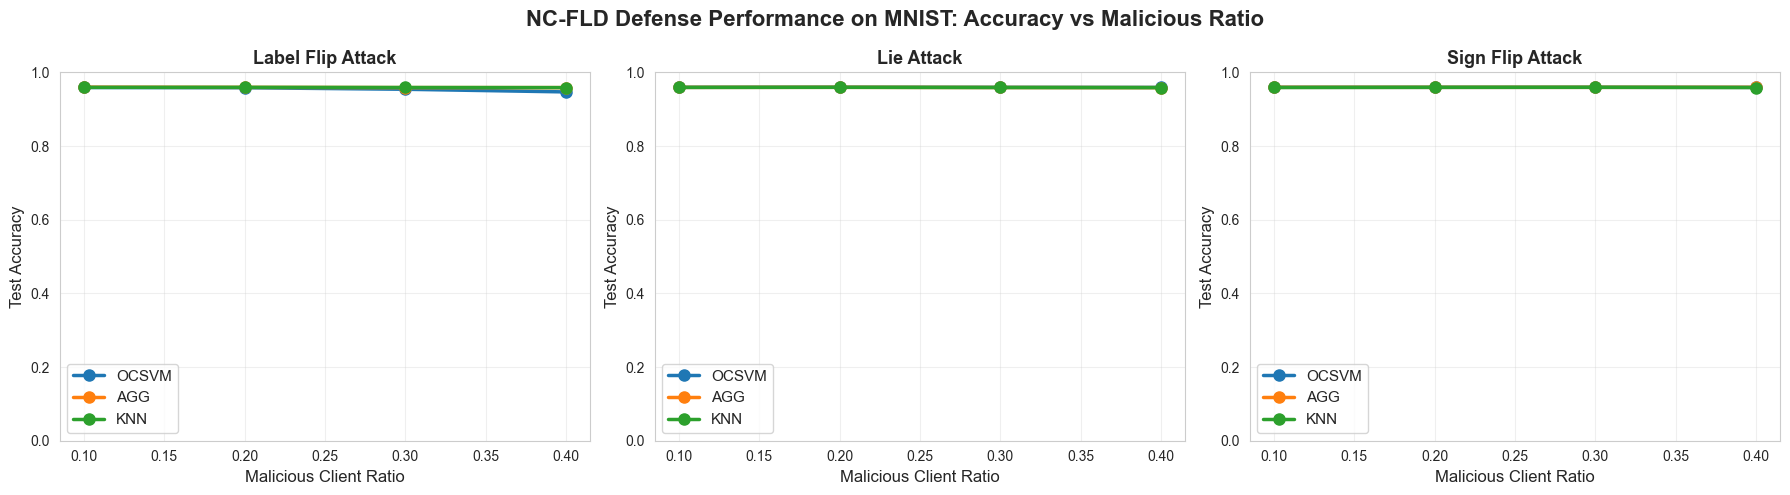

In [25]:
# Plot accuracy vs malicious ratio (MNIST only)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('NC-FLD Defense Performance on MNIST: Accuracy vs Malicious Ratio', 
             fontsize=16, fontweight='bold')

# Filter for MNIST only
df_mnist = df[df['dataset'] == 'mnist']
attacks = df_mnist['attack'].unique()

for j, attack in enumerate(attacks):
    ax = axes[j]
    data = df_mnist[df_mnist['attack'] == attack]
    
    if len(data) > 0:
        for defense in ['ocsvm', 'agg', 'knn']:
            defense_data = data[data['defense'] == defense].sort_values('malicious_ratio')
            if len(defense_data) > 0:
                ax.plot(defense_data['malicious_ratio'], 
                       defense_data['final_accuracy'],
                       marker='o', label=defense.upper(), linewidth=2.5, markersize=8)
        
        ax.set_xlabel('Malicious Client Ratio', fontsize=12)
        ax.set_ylabel('Test Accuracy', fontsize=12)
        ax.set_title(f'{attack.replace("_", " ").title()} Attack', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('mnist_accuracy_vs_malicious_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 2: Defense Method Comparison

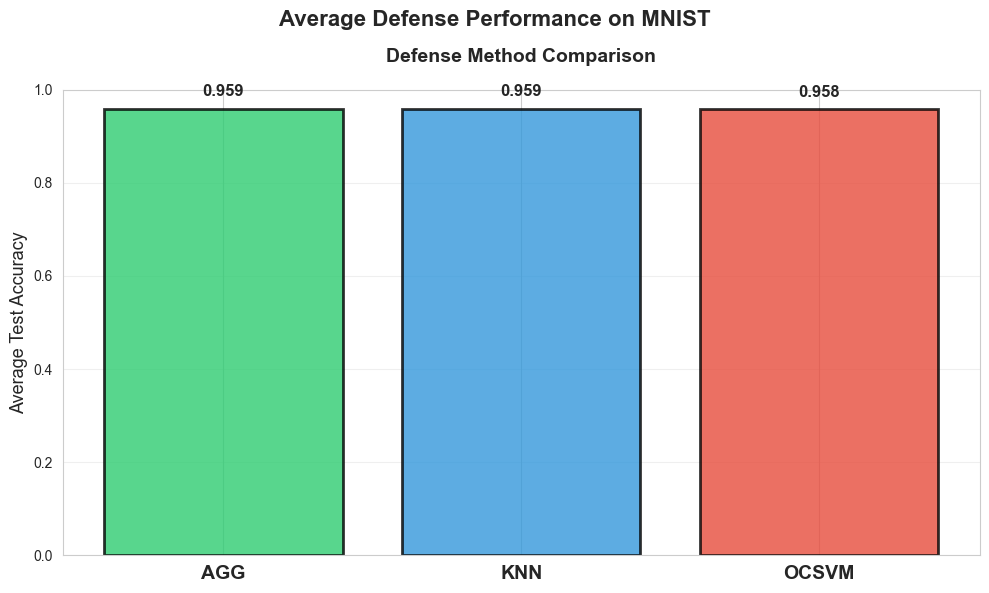

In [26]:
# Bar plot comparing defense methods (MNIST only)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Average Defense Performance on MNIST', fontsize=16, fontweight='bold')

# Filter for MNIST only
df_mnist = df[df['dataset'] == 'mnist']
defense_avg = df_mnist.groupby('defense')['final_accuracy'].mean().sort_values(ascending=False)

colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax.bar(range(len(defense_avg)), defense_avg.values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_xticks(range(len(defense_avg)))
ax.set_xticklabels([d.upper() for d in defense_avg.index], fontsize=14, fontweight='bold')
ax.set_ylabel('Average Test Accuracy', fontsize=13)
ax.set_title('Defense Method Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
           f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('mnist_defense_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 3: Attack Impact Heatmap

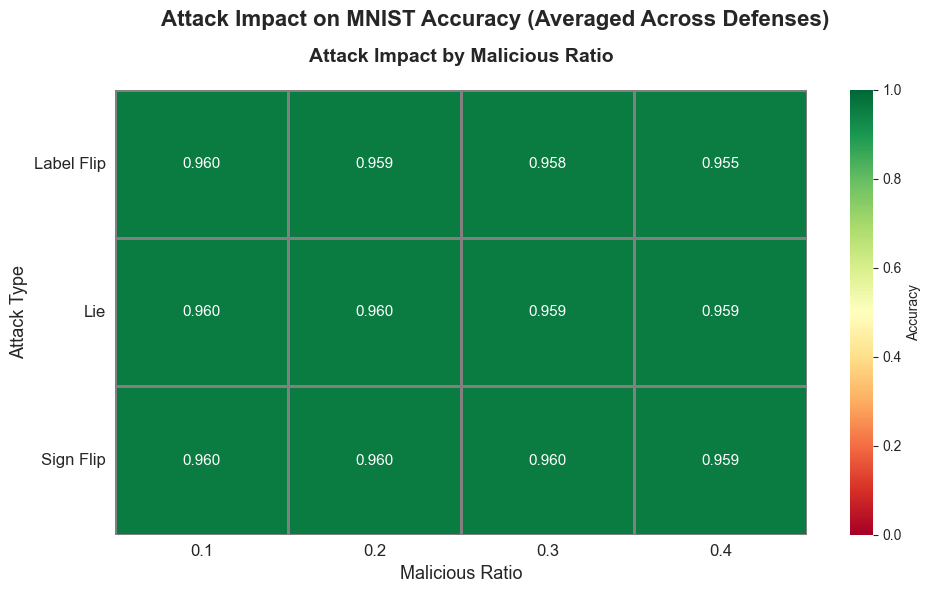

In [27]:
# Heatmap showing attack impact (MNIST only)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Attack Impact on MNIST Accuracy (Averaged Across Defenses)', 
             fontsize=16, fontweight='bold')

# Filter for MNIST only
df_mnist = df[df['dataset'] == 'mnist']

heatmap_data = df_mnist.pivot_table(
    values='final_accuracy',
    index='attack',
    columns='malicious_ratio',
    aggfunc='mean'
)

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Accuracy'},
            linewidths=1, linecolor='gray', annot_kws={'fontsize': 11})
ax.set_title('Attack Impact by Malicious Ratio', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Malicious Ratio', fontsize=13)
ax.set_ylabel('Attack Type', fontsize=13)
ax.set_yticklabels([a.replace('_', ' ').title() for a in heatmap_data.index], rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)

plt.tight_layout()
plt.savefig('mnist_attack_impact_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistical Analysis

In [28]:
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print("\n1. Overall Accuracy Statistics:")
print(df['final_accuracy'].describe())

print("\n2. Best Performing Configurations (Top 10):")
top_10 = df.nlargest(10, 'final_accuracy')[['dataset', 'attack', 'malicious_ratio', 'defense', 'final_accuracy']]
print(top_10.to_string(index=False))

print("\n3. Worst Performing Configurations (Bottom 10):")
bottom_10 = df.nsmallest(10, 'final_accuracy')[['dataset', 'attack', 'malicious_ratio', 'defense', 'final_accuracy']]
print(bottom_10.to_string(index=False))

print("\n4. Average Accuracy by Defense Method:")
defense_stats = df.groupby('defense')['final_accuracy'].agg(['mean', 'std', 'min', 'max', 'count'])
print(defense_stats.to_string())

print("\n5. Average Accuracy by Attack Type:")
attack_stats = df.groupby('attack')['final_accuracy'].agg(['mean', 'std', 'min', 'max', 'count'])
print(attack_stats.to_string())

print("\n6. Average Accuracy by Dataset:")
dataset_stats = df.groupby('dataset')['final_accuracy'].agg(['mean', 'std', 'min', 'max', 'count'])
print(dataset_stats.to_string())

print("\n7. Average Accuracy by Malicious Ratio:")
ratio_stats = df.groupby('malicious_ratio')['final_accuracy'].agg(['mean', 'std', 'min', 'max'])
print(ratio_stats.to_string())


STATISTICAL SUMMARY

1. Overall Accuracy Statistics:
count    36.000000
mean      0.958944
std       0.002206
min       0.947200
25%       0.959175
50%       0.959500
75%       0.959700
max       0.960000
Name: final_accuracy, dtype: float64

2. Best Performing Configurations (Top 10):
dataset     attack  malicious_ratio defense  final_accuracy
  mnist label_flip              0.1     agg          0.9600
  mnist        lie              0.2   ocsvm          0.9599
  mnist  sign_flip              0.3     knn          0.9598
  mnist label_flip              0.2     knn          0.9597
  mnist        lie              0.2     agg          0.9597
  mnist        lie              0.2     knn          0.9597
  mnist  sign_flip              0.1     agg          0.9597
  mnist  sign_flip              0.1   ocsvm          0.9597
  mnist  sign_flip              0.2     knn          0.9597
  mnist  sign_flip              0.3   ocsvm          0.9597

3. Worst Performing Configurations (Bottom 10):
dat

## Generate Comprehensive Report

In [29]:
# Create comprehensive text report
with open('nc_fld_experiment_report.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("NC-FLD FEDERATED LEARNING DEFENSE\n")
    f.write("COMPREHENSIVE EXPERIMENT REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Total Experiments Completed: {len(df)}\n\n")
    
    f.write("="*80 + "\n")
    f.write("OVERALL SUMMARY TABLE\n")
    f.write("="*80 + "\n\n")
    f.write(summary_pivot.to_string())
    f.write("\n\n")
    
    for dataset in datasets:
        f.write("="*80 + "\n")
        f.write(f"{dataset.upper()} DETAILED RESULTS\n")
        f.write("="*80 + "\n\n")
        df_dataset = df[df['dataset'] == dataset]
        pivot = df_dataset.pivot_table(
            values='final_accuracy',
            index=['attack', 'malicious_ratio'],
            columns='defense',
            aggfunc='mean'
        )
        f.write(pivot.to_string())
        f.write("\n\n")
    
    f.write("="*80 + "\n")
    f.write("KEY FINDINGS\n")
    f.write("="*80 + "\n\n")
    
    best_defense = df.groupby('defense')['final_accuracy'].mean().idxmax()
    best_defense_acc = df.groupby('defense')['final_accuracy'].mean().max()
    f.write(f"Best Defense Method: {best_defense.upper()} (Avg Accuracy: {best_defense_acc:.4f})\n")
    
    most_robust = df.groupby('attack')['final_accuracy'].mean().idxmax()
    f.write(f"Most Robust Against: {most_robust.replace('_', ' ').title()} Attack\n")
    
    best_dataset = df.groupby('dataset')['final_accuracy'].mean().idxmax()
    f.write(f"Best Dataset Performance: {best_dataset.upper()}\n")

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nGenerated Files:")
print("  1. nc_fld_experiment_results.csv - Raw results data")
print("  2. summary_accuracy_table.csv - Summary pivot table")
print("  3. mnist_results_table.csv - MNIST detailed results")
print("  4. fmnist_results_table.csv - Fashion-MNIST detailed results")
print("  5. cifar10_results_table.csv - CIFAR-10 detailed results")
print("  6. accuracy_vs_malicious_ratio.png - Line plots")
print("  7. defense_method_comparison.png - Bar charts")
print("  8. attack_impact_heatmap.png - Heatmaps")
print("  9. nc_fld_experiment_report.txt - Comprehensive text report")
print("\n" + "="*80)


ALL EXPERIMENTS COMPLETED SUCCESSFULLY!

Generated Files:
  1. nc_fld_experiment_results.csv - Raw results data
  2. summary_accuracy_table.csv - Summary pivot table
  3. mnist_results_table.csv - MNIST detailed results
  4. fmnist_results_table.csv - Fashion-MNIST detailed results
  5. cifar10_results_table.csv - CIFAR-10 detailed results
  6. accuracy_vs_malicious_ratio.png - Line plots
  7. defense_method_comparison.png - Bar charts
  8. attack_impact_heatmap.png - Heatmaps
  9. nc_fld_experiment_report.txt - Comprehensive text report

